In [83]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp, log
from numpy.linalg import inv, pinv, norm
import pandas as pd
import scipy.optimize as sco
import random

In [84]:
def mouvementBrownien(init, n = 1000):
    w = np.ones(n)*init
    for i in range(1, n):
        yi = np.random.normal()
        w[i] = w[i-1]+(yi/np.sqrt(n))
    return w

In [85]:
def plotNMouvementsBrowniens(N, init, n = 1000):
    for i in range(N):
        plt.plot(mouvementBrownien(init, n))
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.title("Simulation de mouvements browniens")
    plt.show()

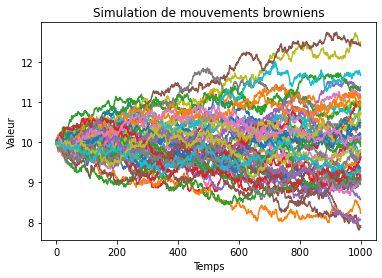

In [86]:
plotNMouvementsBrowniens(50, 10)

In [87]:
def simulationActif(r, sigma, init, n = 1000):
    w = mouvementBrownien(init, n)
    for i in range(1, n):
        w[i] = w[0]*exp((r - (sigma**2)/2) + sigma*w[i])
    return w

In [88]:
def plotActifs(assets):
    for asset in np.transpose(assets):
        plt.plot(asset)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.title("Actifs")
    plt.show()

In [89]:
def matriceRendements(assets): # Renvoie matrice des rendements des N actifs pour les M jours
    M, N = assets.shape
    R = np.zeros((M, N)) 
    for j in range(N):
        for i in range(M-1):
            R[i, j] = log(assets[i+1, j]/assets[i, j])
    return R

In [90]:
# Rendements annuels moyens de chacun des N actifs à partir de la matrice des rendements
def rendementsMoyensAnnuels(R, Nt):
    M, N = R.shape
    E = np.zeros(N) 
    for j in range(N):
        for i in range(M):
            E[j] += R[i, j]
        E[j] *= Nt/(M-1)
    return E

In [91]:
def esperancesSiSj(R): # Matrice des espérances de S_i et S_j
    M, N = R.shape
    Eij = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            for k in range(M):
                Eij[i, j] += R[k, i] * R[k, j]
            Eij[i, j] /= (M-1)
    return Eij

In [92]:
def matriceCovariances(R, Eij, Nt):
    M = R.shape[0]
    gamma = (1/M*R.T@R - Eij.T@Eij)*Nt
    return gamma

In [93]:
def calculABC(gamma_inv, E):
    N = len(E)
    u = np.ones(N)
    A = np.dot(np.transpose(u), np.dot(gamma_inv, E))
    B = np.dot(np.transpose(u), np.dot(gamma_inv, u))
    C = np.dot(np.transpose(E), np.dot(gamma_inv, E))
    return A, B, C

In [94]:
# Renvoie un tableau N valeurs comprises entre a et b, suivant une loi uniforme et de somme 1
def allocation(N, a, b): 
    U = np.random.uniform(a, b, N)
    s = np.sum(U)
    X = [x/s for x in U]
    return X

In [95]:
def fonctionRepartition(Rhat, a, b, Nx = 100):
    Nmc = len(Rhat)
    dx = (b - a)/Nx
    x = [a + dx*k for k in range(Nx)]
    p = np.zeros(Nx)
    for k in range(Nx):
        cpt = 0
        for n in range(Nmc):
            if Rhat[n] <= x[k]:
                cpt += 1
        p[k] = cpt/Nmc
    return x, p

## Frontière efficiente de Markowitz et génération de portefeuilles aléatoires

### Cas 1: Exemple d'un toy-model

In [96]:
gamma = np.array([[0.5, 0.3, 0.05], [0.3, 0.3, 0.1], [0.05, 0.1, 0.8]])
E = np.array([1, 2, 3])
u = np.ones(3)

In [97]:
gamma_inv = inv(gamma)
A, B, C = calculABC(gamma_inv, E)
print(A, B, C)

8.508287292817679 3.922651933701658 24.088397790055247


0.5914177880314389


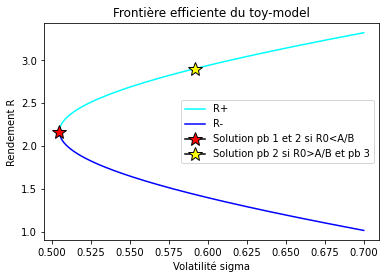

In [98]:
# Affichage de la frontière efficiente
a, b, n = 1/sqrt(B), 0.7, 1000
h = (b-a)/n
sigma_values = [a + i*h for i in range(n)]
Rp = [A/B + sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma_values]
Rn = [A/B - sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma_values]
plt.plot(sigma_values, Rp, color = "cyan")
plt.plot(sigma_values, Rn, color = "blue")
plt.ylabel("Rendement R")
plt.xlabel("Volatilité sigma")
plt.title("Frontière efficiente du toy-model")

# Probleme 1: minimiser le risque
# Or le risque est minimal en sigma² = 1/B et R = A/B
plt.plot([1/sqrt(B)], [A/B], marker = "*", markersize = 15, color = "black", markerfacecolor = "red")

# Problème 2: minimiser le risque avec un rendement minimal R0
# Si R0 <= A/B -> solution du problème 1
# Si R0 > A/B
R0 = 2.9
sigma0 = sqrt(1/B*(R0*B-A)**2/(C*B-A*A) + 1/B)
print(sigma0)
plt.plot([sigma0], [R0], marker = "*", markersize = 15, color = "black", markerfacecolor = "yellow")

# Problème 3: maximiser le rendement avec un volatilité sigma1 donné
# Même solution que problème 2 en prenant sigma1 = sigma0

# Portefeuille trouvé avec l'algo amélioré de descente cyclique des coordonnées
#plt.scatter([0.5178361868848506], [1.9307294709354834], color = 'red')

plt.legend(["R+", "R-", "Solution pb 1 et 2 si R0<A/B", "Solution pb 2 si R0>A/B et pb 3"])
plt.show()

### Cas 2: Modèle de Black & Scholes

In [99]:
r = 0.1
sigma = 0.5
M = 252
Nt = 252
N = 10

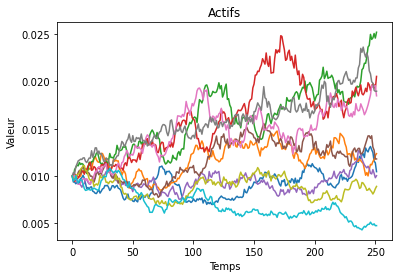

In [100]:
# Simulation des actifs
assets = np.transpose([simulationActif(r, sigma, 0.01, M) for i in range(N)])
# Affichage des actifs simulés
plotActifs(assets)

In [101]:
R = matriceRendements(assets)
E = rendementsMoyensAnnuels(R, Nt)
gamma = matriceCovariances(R, esperancesSiSj(R), Nt)
gamma_inv = inv(gamma)
A, B, C = calculABC(gamma_inv, E)

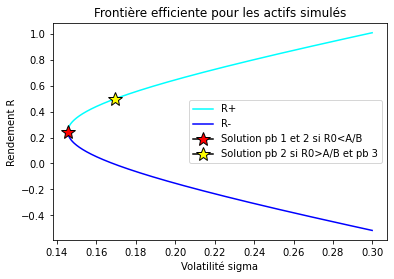

In [102]:
# Affichage de la frontière efficiente
a, b, n = 1/sqrt(B), 0.3, 1000
h = (b-a)/n
sigma = [a + i*h for i in range(n)]
Rp = [A/B + sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma]
Rn = [A/B - sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma]
plt.plot(sigma, Rp, color = "cyan")
plt.plot(sigma, Rn, color = "blue")
plt.ylabel("Rendement R")
plt.xlabel("Volatilité sigma")
plt.title("Frontière efficiente pour les actifs simulés")

# Probleme 1: minimiser le risque
# Or le risque est minimal en sigma² = 1/B et R = A/B
plt.plot([1/sqrt(B)], [A/B], marker = "*", markersize = 15, color = "black", markerfacecolor = "red")

# Problème 2: minimiser le risque avec un rendement minimal R0
# Si R0 <= A/B -> solution du problème 1
# Si R0 > A/B
R0 = 0.5
sigma0 = sqrt(1/B*(R0*B-A)**2/(C*B-A*A) + 1/B)
plt.plot([sigma0], [R0], marker = "*", markersize = 15, color = "black", markerfacecolor = "yellow")

# Problème 3: maximiser le rendement avec un volatilité sigma1 donné
# Même solution que problème 2 en prenant sigma1 = sigma0

plt.legend(["R+", "R-", "Solution pb 1 et 2 si R0<A/B", "Solution pb 2 si R0>A/B et pb 3", "Nos actifs"])
plt.show()

In [103]:
# Simulation des portefeuilles aléatoires
Nmc = 10000
R_portefeuilles, risque_portefeuilles = [], []
for i in range(Nmc):
    X = allocation(N, 0, 1)
    R_portefeuilles.append(X@E)
    risque_portefeuilles.append(X@gamma@np.transpose(X))

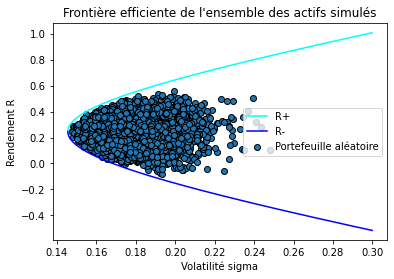

In [104]:
plt.plot(sigma, Rp, color = "cyan")
plt.plot(sigma, Rn, color = "blue")
plt.ylabel("Rendement R")
plt.xlabel("Volatilité sigma")
plt.title("Frontière efficiente de l'ensemble des actifs simulés")

# Affichage des portefeuilles aléatoires
plt.scatter([sqrt(x) for x in risque_portefeuilles], R_portefeuilles, marker = "o", edgecolors = "black")

plt.legend(["R+", "R-", "Portefeuille aléatoire"])
plt.show()

### Cas 3: Données du CAC40

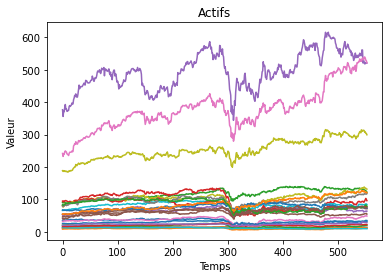

In [105]:
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
plotActifs(CAC40)

In [106]:
Nt = 252
M, N = CAC40.shape
R = matriceRendements(CAC40)
E = rendementsMoyensAnnuels(R, Nt)
gamma = matriceCovariances(R, esperancesSiSj(R), Nt)
gamma_inv = inv(gamma)
A, B, C = calculABC(gamma_inv, E)

0.23998894779509095


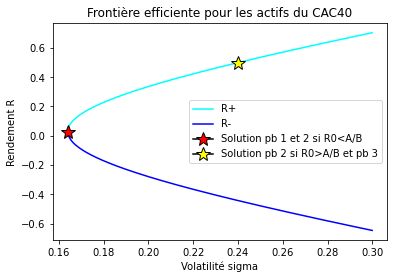

In [107]:
# Affichage de la frontière efficiente
a, b, n = 1/sqrt(B), 0.3, 1000
h = (b-a)/n
sigma = [a + i*h for i in range(n)]
Rp = [A/B + sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma]
Rn = [A/B - sqrt(abs((x*x*B-1)*(B*C-A*A)))/B for x in sigma]
plt.plot(sigma, Rp, color = "cyan")
plt.plot(sigma, Rn, color = "blue")
plt.ylabel("Rendement R")
plt.xlabel("Volatilité sigma")
plt.title("Frontière efficiente pour les actifs du CAC40")

# Probleme 1: minimiser le risque
# Or le risque est minimal en sigma² = 1/B et R = A/B
plt.plot([1/sqrt(B)], [A/B], marker = "*", markersize = 15, color = "black", markerfacecolor = "red")

# Problème 2: minimiser le risque avec un rendement minimal R0
# Si R0 <= A/B -> solution du problème 1
# Si R0 > A/B
R0 = 0.5
sigma0 = sqrt(1/B*(R0*B-A)**2/(C*B-A*A) + 1/B)
print(sigma0)
plt.plot([sigma0], [R0], marker = "*", markersize = 15, color = "black", markerfacecolor = "yellow")

# Problème 3: maximiser le rendement avec un volatilité sigma1 donné
# Même solution que problème 2 en prenant sigma1 = sigma0

# Solution trouvée avec CCD amélioré pour contrainte X>=0
# plt.scatter([0.22478419626043475], [0.1515749646918127], color ='red')


plt.legend(["R+", "R-", "Solution pb 1 et 2 si R0<A/B", "Solution pb 2 si R0>A/B et pb 3"])
plt.show()

In [108]:
# Risque minimal
print(f"Risque: {1/sqrt(B)}. Pour un rendement de: {A/B}")

Risque: 0.16403003088931692. Pour un rendement de: 0.028550876413982466


In [109]:
# Simulation des portefeuilles aléatoires
Nmc = 100000
R_portefeuilles, risque_portefeuilles = [], []
for i in range(Nmc):
    X = allocation(N, 0, 1)
    R_portefeuilles.append(X@E)
    risque_portefeuilles.append(X@gamma@np.transpose(X))

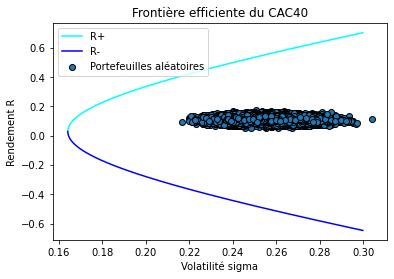

In [110]:
plt.plot(sigma, Rp, color = "cyan")
plt.plot(sigma, Rn, color = "blue")
plt.ylabel("Rendement R")
plt.xlabel("Volatilité sigma")
plt.title("Frontière efficiente du CAC40")

# Affichage des portefeuilles aléatoires
plt.scatter([sqrt(x) for x in risque_portefeuilles], R_portefeuilles, marker = "o", edgecolors = "black")

plt.legend(["R+", "R-", "Portefeuilles aléatoires"])
plt.show()

## Value at Risk

In [234]:
nal = 5
nac = 10
risqs = [0.1, 2, 0.5, 1.5, 4]
rends = [0.5, 0.1, 3, 0.05, 0.01]

In [235]:
allocations = []
allocations.append(np.array([1/nac for j in range(nac)]))
for k in range(nal - 1):
    allocations.append(allocation(nac, 0, 1))

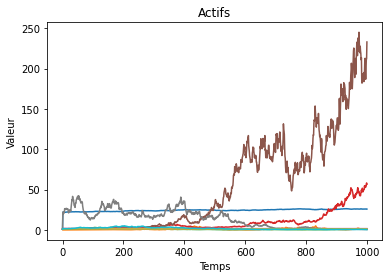

In [236]:
actifs = np.array([simulationActif(random.choice(rends), random.choice(risqs), 1) for k in range(nac)])
plotActifs(np.transpose(actifs))

In [237]:
R = matriceRendements(np.transpose(actifs))

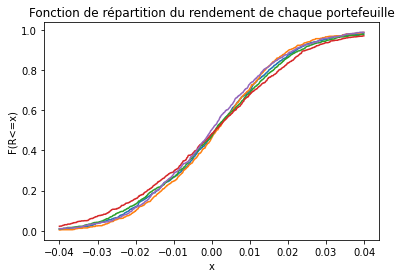

In [238]:
xs = []
ps = []
for X in allocations:
    Rhat = np.zeros(1000)
    for i in range(1000):
        for j in range(nac):
            Rhat[i] += X[j]*R[i, j]
    x, p = fonctionRepartition(Rhat, -0.04, 0.04, 1000)
    xs.append(x)
    ps.append(p)
    plt.plot(x, p)
plt.title("Fonction de répartition du rendement de chaque portefeuille")
plt.xlabel("x")
plt.ylabel("F(R<=x)")
plt.show()

For portefolio 0, VaR of R for a level of confidence of 0.9 is 0.022160000000000006.


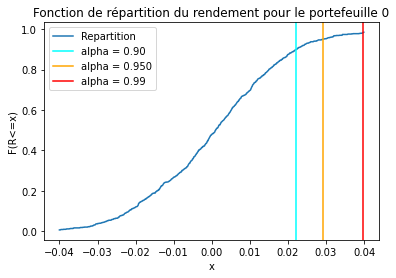

For portefolio 1, VaR of R for a level of confidence of 0.9 is 0.02024.


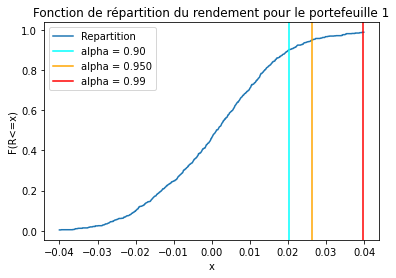

For portefolio 2, VaR of R for a level of confidence of 0.9 is 0.02344000000000001.


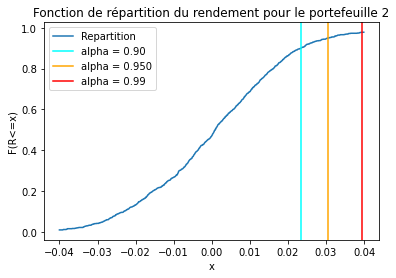

For portefolio 3, VaR of R for a level of confidence of 0.9 is 0.02472.


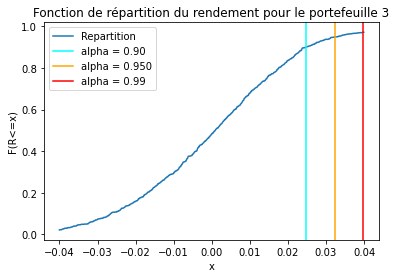

For portefolio 4, VaR of R for a level of confidence of 0.9 is 0.0216.


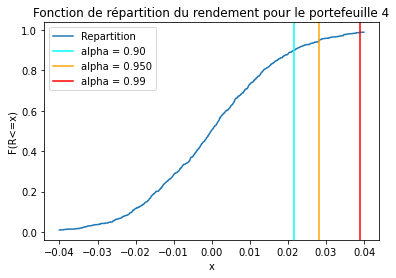

In [239]:
alpha1, alpha2, alpha3 = 0.90, 0.95, 0.99
VaRs = []
for alloc in range(nal):
    index = min(range(len(ps[alloc])), key = lambda i: abs(ps[alloc][i]-alpha1))
    VaR = xs[alloc][index]
    VaRs.append(VaR)
    VaR2 = xs[alloc][min(range(len(ps[alloc])), key = lambda i: abs(ps[alloc][i]-alpha2))]
    VaR3 = xs[alloc][min(range(len(ps[alloc])), key = lambda i: abs(ps[alloc][i]-alpha3))]
    print(f"For portefolio {alloc}, VaR of R for a level of confidence of {ps[alloc][index]} is {xs[alloc][index]}.")
    plt.plot(xs[alloc], ps[alloc])
    plt.axvline(x = VaR, color = 'cyan', label = 'axvline - full height')
    plt.axvline(x = VaR2, color = 'orange', label = 'axvline - full height')
    plt.axvline(x = VaR3, color = 'red', label = 'axvline - full height')
    plt.title(f"Fonction de répartition du rendement pour le portefeuille {alloc}")
    plt.xlabel("x")
    plt.ylabel("F(R<=x)")
    plt.legend(["Repartition", "alpha = 0.90", "alpha = 0.950", "alpha = 0.99"])
    plt.show()

## Algorithmes de résolution numérique

#### Algorithme de Newton

In [114]:
def newton(grad, hessien, x0, eps = 10**(-4), Nmax = 200):
    x = np.copy(x0)
    d = np.ones(len(x))
    k = 0
    while grad(x)@np.transpose(d) > eps and k < Nmax:
        d = -inv(hessien(x))@np.transpose(grad(x))
        x += d
        k += 1
    return x, k

In [116]:
# Application à un toy model pour la minimisation du risque

gamma = np.array([[0.5, 0.3, 0.05], [0.3, 0.3, 0.1], [0.05, 0.1, 0.8]])
E = np.array([1, 2, 3])

def grad(x):
    n = len(x)
    res = np.array([2*gamma[k]@np.transpose(x) for k in range(n)])
    return res

def hessien(x):
    n = len(x)
    res = np.array([[2*gamma[i, j] for i in range(n)] for j in range(n)])
    return res

Nmax = 100
eps = 0.0001
x0 = np.array([1/3, 1/3, 1/3])
xsol, nb_ite = newton(grad, hessien, x0, eps, Nmax)
print(f"La solution est: {xsol} (obtenue après {nb_ite} itération(s))")

La solution est: [ 2.77555756e-16 -3.88578059e-16  5.55111512e-17] (obtenue après 1 itération(s))


### Minimisation avec contrainte(s) égalité: Lagrange-Newton

In [117]:
def lagrange_newton(r0, nb_var, ctn, ctn_grad, lagr_grad, lagr_hessien,  eps = 10**(-3), Nmax = 500):
    n = nb_var
    p = len(r0) - n
    r = np.copy(r0)
    d_et_zeta = np.ones(n+p)
    k = 0
    tmp = 100*d_et_zeta
    while sqrt(d_et_zeta@np.transpose(d_et_zeta)) > eps and k < Nmax:
        hess_lagr = lagr_hessien(r, n)
        grad_ctn = ctn_grad(r, n)
        grad_lagr = lagr_grad(r, n)
        H1 = np.concatenate((hess_lagr, grad_ctn))
        H2 = np.concatenate((np.transpose(grad_ctn), np.zeros((p, p))))
        H = np.concatenate((H1, H2), axis = 1)
        G = np.concatenate((grad_lagr, ctn(r[:n])))
        tmp = np.copy(d_et_zeta)
        d_et_zeta = -inv(H)@G
        r = r + d_et_zeta
        k = k+1
    return r, k

In [119]:
# Application au toy model
# Minimisation du risque avec contrainte de rendement et de somme des allocations

def ctn(X):
    c1 = X@E - R0
    c2 = np.sum(X) - 1
    return np.array([c1, c2])

def ctn_grad(X, n):
    c1 = E
    c2 = np.ones(n)
    return np.array([c1, c2])

def lagr_grad(X, n):
    f = 2*np.array([gamma[:, i]@X[:n] for i in range(n)])
    h1 = X[n]*E
    h2 = X[n+1]*np.ones(n)
    return f + h1 + h2

def lagr_hessien(X, n):
    return gamma

R0 = 3.5
r0 = [1/3, 1/3, 1/3, 1, 1]
nb_var = 3
r_sol, nb_ite = lagrange_newton(r0, nb_var, ctn, ctn_grad, lagr_grad, lagr_hessien, eps = 0.001, Nmax = 20000)
print(f"La solution est: {r_sol} (obtenue après {nb_ite} itérations)\n")

risque = r_sol[:3]@gamma@r_sol[:3]
print(f"La volatilité minimum trouvée sous la contrainte de rendement {R0} est de {sqrt(risque)}")

# On a bien le rendement souhaité et la somme des allocations qui vaut 1
print(f"Rendement: {r_sol[:nb_var]@E}\nSomme des allocations: {np.sum(r_sol[:nb_var])}")

La solution est: [-0.94166667  1.38333333  0.55833333 -0.4725      0.515     ] (obtenue après 20000 itérations)

La volatilité minimum trouvée sous la contrainte de rendement 3.5 est de 0.7662589495580321
Rendement: 3.5
Somme des allocations: 1.0


In [120]:
# Application au toy-model
# Minimisation du risque avec uniquement la contrainte de somme des allocations

def ctn(X):
    c1 = np.sum(X) - 1
    return np.array([c1]) 

def ctn_grad(X, n):
    c1 = np.ones(n)
    return np.array([c1])

def lagr_grad(X, n):
    f = 2*np.array([gamma[:, i]@X[:n] for i in range(n)])
    h1 = X[n]*np.ones(n)
    return f + h1

def lagr_hessien(X, n):
    return gamma

r0 = [1/3, 1/3, 1/3, 1]
nb_var = 3
r_sol, nb_ite = lagrange_newton(r0, nb_var, ctn, ctn_grad, lagr_grad, lagr_hessien, Nmax = 500)
print(f"La solution est: {r_sol} (obtenue après {nb_ite} itérations)\n")

risque = r_sol[:3]@gamma@r_sol[:3]
print(f"Le risque minimum trouvé est {sqrt(risque)}")
print(f"Le rendement associé est: {E@r_sol[:3]}")

La solution est: [ 0.33333333  0.33333333  0.33333333 -0.50985915] (obtenue après 500 itérations)

Le risque minimum trouvé est 0.5270462766947297
Le rendement associé est: 2.000000000000003


In [121]:
# Données CAC40
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
Nt = 252
R = matriceRendements(CAC40)
E = rendementsMoyensAnnuels(R, Nt)
gamma = matriceCovariances(R, esperancesSiSj(R), Nt)

In [123]:
# Application aux CAC40
# Minimisation du risque avec contrainte somme des r_i = 1 

def ctn(X):
    c1 = X@np.ones(len(X)) - 1
    return np.array([c1])

def ctn_grad(X, n):
    c1 = np.ones(n)
    return np.array([c1])

def lagr_grad(X, n):
    f = np.array([gamma[:, i]@X[:n] for i in range(n)])
    h = X[n]*np.ones(n)
    return f + h

def lagr_hessien(X, n):
    return gamma


r0 = [1/N for i in range(N)]
r0.append(1)
nb_var = N
r_sol, nb_ite = lagrange_newton(r0, nb_var, ctn, ctn_grad, lagr_grad, lagr_hessien)
print(f"La solution est: {r_sol} (obtenue après {nb_ite} itérations)\n")
print(f"La volatilité minimale trouvée est: {sqrt(r_sol[:N]@gamma@r_sol[:N])}")

# Vérifions que la somme des allocations vaut bien 1 et calculons le rendement
print(f"Somme des allocations: {np.sum(r_sol[:N])}\n")
print(f"Rendement: {r_sol[:N]@E}")

La solution est: [ 0.04988556  0.00948531  0.16144481 -0.0173461  -0.01947615  0.18001123
  0.0329461   0.10593325  0.05263519 -0.21036008 -0.05912804 -0.04061208
 -0.09854452  0.0541652   0.02062787  0.03009351  0.02193049  0.10842816
  0.08668131  0.18106885  0.25824386 -0.10772355  0.07742679  0.01001378
  0.05976463  0.0524046  -0.02690585] (obtenue après 2 itérations)

La volatilité minimale trouvée est: 0.1640300308893169
Somme des allocations: 0.9999999999999999

Rendement: 0.028550876413982566


In [125]:
# Application au CAC40
# Minimisation du risque avec contraintes de rendement et de somme des allocations 

def ctn(X):
    c1 = X@E - R0
    c2 = X@np.ones(len(X)) - 1
    return np.array([c1, c2])

def ctn_grad(X, n):
    c1 = E
    c2 = np.ones(n)
    return np.array([c1, c2])

def lagr_grad(X, n):
    f = np.array([gamma[:, i]@X[:n] for i in range(n)])
    h1 = X[n]*E
    h2 = X[n+1]*np.ones(n)
    return f + h1 + h2

def lagr_hessien(X, n):
    return gamma


R0 = 0.02855
r0 = [1/N for i in range(N)]
r0.append(1)
r0.append(1)
nb_var = N
r_sol, nb_ite = lagrange_newton(r0, nb_var, ctn, ctn_grad, lagr_grad, lagr_hessien)
print(f"La solution est: {r_sol} (obtenue après {nb_ite} itérations)\n")
print(f"La volatilité minimale trouvée est: {sqrt(r_sol[:N]@gamma@r_sol[:N])}")

# Vérifions que la somme des allocations vaut bien 1 et que le rendement est celui souhaité
print(f"Somme des allocations: {np.sum(r_sol[:N])}")
print(f"Rendement: {r_sol[:N]@E}")

La solution est: [ 4.98856786e-02  9.48522029e-03  1.61444877e-01 -1.73460599e-02
 -1.94759320e-02  1.80011346e-01  3.29457286e-02  1.05933334e-01
  5.26350806e-02 -2.10360033e-01 -5.91280702e-02 -4.06118954e-02
 -9.85441615e-02  5.41656148e-02  2.06283535e-02  3.00935849e-02
  2.19296632e-02  1.08428077e-01  8.66810225e-02  1.81069696e-01
  2.58244113e-01 -1.07724308e-01  7.74267702e-02  1.00134642e-02
  5.97643462e-02  5.24044898e-02  1.21009694e-07 -2.69058545e-02] (obtenue après 2 itérations)

La volatilité minimale trouvée est: 0.16403003088964016
Somme des allocations: 1.0
Rendement: 0.028550000000000006


### Algorithme d'Uzawa : fonction quadratique et contraintes égalité

In [128]:
def meth_grad_pas_constant(A, b, x0, eps, N):
    x = np.copy(x0)
    x2 = 1000*np.copy(x0)
    cpt = 0
    while norm(x2 - x) >= eps * norm(x) and cpt < N:
        d = -(A@x + b)
        p = 0.001
        x2 = x
        x = x + p*d
        cpt += 1
    r = norm(A@x+b)
    return x, cpt, r

In [129]:
def uzawa(A, b, Q, c, p, x0, mu0, eps = 10**(-3), Nmax = 200):
    x = np.copy(x0)
    mu = np.copy(mu0)
    cpt = 0
    while norm(Q@x - c) > eps and cpt < Nmax:
        x = meth_grad_pas_constant(A, b+np.transpose(Q)@mu, x, eps, N)[0]  # enlever les retour de meth_grad qd testé
        mu = mu + p*(Q@x - c)
        cpt += 1
    return x, mu, cpt

In [130]:
# Données toy-model
gamma = np.array([[0.5, 0.3, 0.05], [0.3, 0.3, 0.1], [0.05, 0.1, 0.8]])
E = np.array([1, 2, 3])
N = 3

In [134]:
# Application au toy
# Minimisation du risque avec contraintes de rendement et de somme des allocations

A = 2*gamma
b = np.zeros(N)
p = 1
R0 = -0.35
Q = np.array([E, np.ones(N)])
c = np.array([R0, 1])
mu0 = np.array([1, 1])
x0 = np.array([1/N for i in range(N)])

x, mu, k = uzawa(A, b, Q, c, p, x0, mu0, Nmax = 50000)
print(f"Vecteur x solution: {x}\nMultiplicateurs de Lagrange: {mu}\nNombre d'itérations: {k}\n")
print(f"La volatilité trouvée est {sqrt(x@gamma@x)}")

print(f"Somme des allocations: {np.sum(x)}")
print(f"Rendement: {E@x}")

Vecteur x solution: [ 2.00354903 -0.65803807 -0.34568244]
Multiplicateurs de Lagrange: [ 1.94400083 -5.61892445]
Nombre d'itérations: 1443

La volatilité trouvée est 1.190711558663703
Somme des allocations: 0.9998285203649795
Rendement: -0.3495744294563048


In [136]:
# Application au toy-model
# Minimisation du risque sans contrainte de rendement

Q = np.array([np.ones(N)])
c = np.array([1])
mu0 = np.array([1])
x0 = np.zeros(N)

x, mu, k = uzawa(A, b, Q, c, p, x0, mu0, Nmax = 50000)
print(f"Vecteur x solution: {x}\nMultiplicateurs de Lagrange: {mu}\nNombre d'itérations: {k}\n")
print(f"La volatilité trouvée est {sqrt(x@gamma@x)}")
print(f"Somme des allocations: {np.sum(x)}")
print(f"Rendement: {E@x}")

Vecteur x solution: [0.28713524 0.43694476 0.27628427]
Multiplicateurs de Lagrange: [-3.25290859]
Nombre d'itérations: 548

La volatilité trouvée est 0.5166435580236481
Somme des allocations: 1.0003642637472112
Rendement: 1.9898775592003564


In [137]:
# Données CAC40
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
Nt = 252
R = matriceRendements(CAC40)
E = rendementsMoyensAnnuels(R, Nt)
gamma = matriceCovariances(R, esperancesSiSj(R), Nt)

In [139]:
# Application au CAC40
# Minimisation du risque avec contraintes de rendement et de somme des allocations

A = 2*gamma
b = np.zeros(N)
p = 1
R0 = 1.5
Q = np.array([E, np.ones(N)])
c = np.array([R0, 1])
mu0 = np.array([1, 1])
x0 = np.array([1/N for i in range(N)])

x, mu, k = uzawa(A, b, Q, c, p, x0, mu0, Nmax = 50000)
print(f"Vecteur x solution: {x}\nMultiplicateurs de Lagrange: {mu}\nNombre d'itérations: {k}\n")
print(f"La volatilité trouvée est {sqrt(x@gamma@x)}")
print(f"Somme des allocations: {np.sum(x)}")
print(f"Rendement: {E@x}")

Vecteur x solution: [-0.27412364  0.14412721  0.08183712 -0.09508214 -0.34138366 -0.15490971
  0.55326367 -0.17341913  0.330869   -0.14044593 -0.05389296 -0.27577032
 -0.60662149 -0.7294301  -0.34793466  0.20405349  1.12217741  0.26065164
  0.57205844 -1.10203662 -0.21049262  1.10510254 -0.05595163  0.42781469
  0.49125748  0.26827333]
Multiplicateurs de Lagrange: [-4.71538496  0.43979149]
Nombre d'itérations: 800

La volatilité trouvée est 0.590382009223694
Somme des allocations: 0.9999914103690766
Rendement: 1.500803875516435


In [140]:
# Application au CAC40
# Minimisation du risque sans contrainte de rendement

Q = np.array([np.ones(N)])
c = np.array([1])
mu0 = np.array([1])
x0 = np.zeros(N)

x, mu, k = uzawa(A, b, Q, c, p, x0, mu0, Nmax = 50000)
print(f"Vecteur x solution: {x}\nMultiplicateurs de Lagrange: {mu}\nNombre d'itérations: {k}\n")
print(f"La volatilité trouvée est {sqrt(x@gamma@x)}")
print(f"Somme des allocations: {np.sum(x)}")
print(f"Rendement: {E@x}")

Vecteur x solution: [-0.00100865 -0.01471329  0.08420327 -0.04653067  0.03784764  0.11682773
 -0.01579869  0.09880263  0.04082113 -0.02961169 -0.01433235  0.03416611
 -0.06257664  0.04516303  0.03441472  0.04893433  0.04549997  0.04773155
  0.09265493  0.10291941  0.13119258  0.02622033  0.02956229  0.04864838
  0.08689663  0.03110384]
Multiplicateurs de Lagrange: [-0.13581393]
Nombre d'itérations: 257

La volatilité trouvée est 0.1790739720894934
Somme des allocations: 0.9990385568411815
Rendement: 0.09746788483199491


### Algorithme: improved Cyclical Coordinate Descent

In [141]:
def improved_CCD(gamma, eps = 10**(-3), Nmax = 1000):
    N = len(gamma)
    # Calcul de la matrice de corrélation et du vecteur des écart-types
    R = np.array([[gamma[i, j]/sqrt(gamma[i, i]*gamma[j, j]) for j in range(N)] for i in range(N)])
    sigma = np.array([sqrt(gamma[i, i]) for i in range(N)])
    # Risk parity
    b = np.ones(N)
    # Initialisation des allocations
    w = np.ones(N)/sum(R)
    # Initialisation du compteur d'itérations
    cpt = 0
    while max(np.array([abs(w[i]*(R@w)[i]- b[i]) for i in range(N)])) and cpt < Nmax:
        for i in range(N):
            a = 0
            for j in range(N):
                if j != i:
                    a += 0.5*R[i, j]*w[j]
            w[i] = sqrt(a*a + b[i])
        w = w/sqrt(w@R@w)
        v = np.array([w[i]/sigma[i] for i in range(N)])
        cpt += 1
        return v/sum(v), cpt

In [142]:
# Données toy-model
gamma = np.array([[0.5, 0.3, 0.05], [0.3, 0.3, 0.1], [0.05, 0.1, 0.8]])
E = np.array([1, 2, 3])
N = 3

In [143]:
# Application au toy-model
w, cpt = improved_CCD(gamma)
print(f"Allocations: {w}. \nRendement: {E@w}\nVolatilité: {sqrt(w@gamma@w)}")
print(f"Somme des allocations: {sum(w)}\nNombre d'itérations: {cpt}")

Allocations: [0.31497244 0.43932565 0.24570191]. 
Rendement: 1.9307294709354834
Volatilité: 0.5178361868848506
Somme des allocations: 1.0
Nombre d'itérations: 1


In [144]:
# Données CAC40
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
CAC40 = np.genfromtxt('dataCAC40.csv', delimiter = ",", skip_header = 1)
CAC40 = np.delete(CAC40, obj = 0, axis = 1)
M, N = CAC40.shape
Nt = 252
R = matriceRendements(CAC40)
E = rendementsMoyensAnnuels(R, Nt)
gamma = matriceCovariances(R, esperancesSiSj(R), Nt)

In [145]:
# Application au CAC40
w, cpt = improved_CCD(gamma)
print(f"Allocations: {w}. \nRendement: {E@w}\nVolatilité: {sqrt(w@gamma@w)}")
print(f"Somme des allocations: {sum(w)}\nNombre d'itérations: {cpt}")

Allocations: [0.0007482  0.00095131 0.00183723 0.00103826 0.00158648 0.00252125
 0.00230872 0.00276799 0.00336552 0.00473087 0.00655414 0.00950537
 0.00779717 0.01384673 0.01750273 0.02606169 0.03590988 0.04089668
 0.05975054 0.07024409 0.07369824 0.10499118 0.07355778 0.14174863
 0.16864279 0.12743653]. 
Rendement: 0.1515749646918127
Volatilité: 0.22478419626043475
Somme des allocations: 1.0000000000000002
Nombre d'itérations: 1
